#Inpainting of satellite Images

### Imports of required libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization, Conv2DTranspose
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow_datasets as tfds

###Dataset
I split the dataset into train, validation, and test. The validation and test sets consist of 2000 samples to try to have as much training data available as possible.

In [ ]:
ds_train, ds_info = tfds.load(
    'eurosat/rgb',
    shuffle_files=False,
    with_info=True
)

ds_train = ds_train['train']
ds_train = ds_train.shuffle(1000, seed = 42)

train_dataset = ds_train.take(25000)

validation_dataset = train_dataset.take(2000)
train_dataset = train_dataset.skip(2000)
test_dataset = ds_train.skip(25000)

print("Dimensioni del train_dataset:", tf.data.experimental.cardinality(train_dataset).numpy())
print("Dimensioni del validation_dataset:", tf.data.experimental.cardinality(validation_dataset).numpy())
print("Dimensioni del test_dataset:", tf.data.experimental.cardinality(test_dataset).numpy())

Dimensioni del train_dataset: 23000
Dimensioni del validation_dataset: 2000
Dimensioni del test_dataset: 2000


###Generator for masking the images

The generator provided in the initial notebook is used to generate the masks on the images for the different sets of train, test, and validation.

In [ ]:
def generator(dataset,nolines=9):
    while True:
        for batch in dataset:
            images = batch["image"]
            images_np = images.numpy()

            masks = np.zeros((batch_size, 64, 64))
            for i in range(batch_size):
                for j in range(nolines):
                    start_point = (np.random.randint(0, 64 - 1), 0)
                    end_point = (np.random.randint(0, 64 - 1), 63)
                    thickness = np.random.randint(2, 3)
                    masks[i] = cv2.line(masks[i], start_point, end_point, (1), thickness)

            images_np = images_np / 255.0
            masks = np.stack(((masks),) * 3, axis=-1)

            yield (images_np * masks, images_np)

batch_size = 8
train_dataset_batched = train_dataset.batch(batch_size)
validation_dataset_batched = validation_dataset.batch(batch_size)
test_dataset_batched = test_dataset.batch(batch_size)

train_generator = generator(train_dataset_batched)
valid_generator = generator(validation_dataset_batched)
test_generator = generator(test_dataset_batched)

###Original image vs masked image

A visualization of the original satellite images and images masked by the generator.

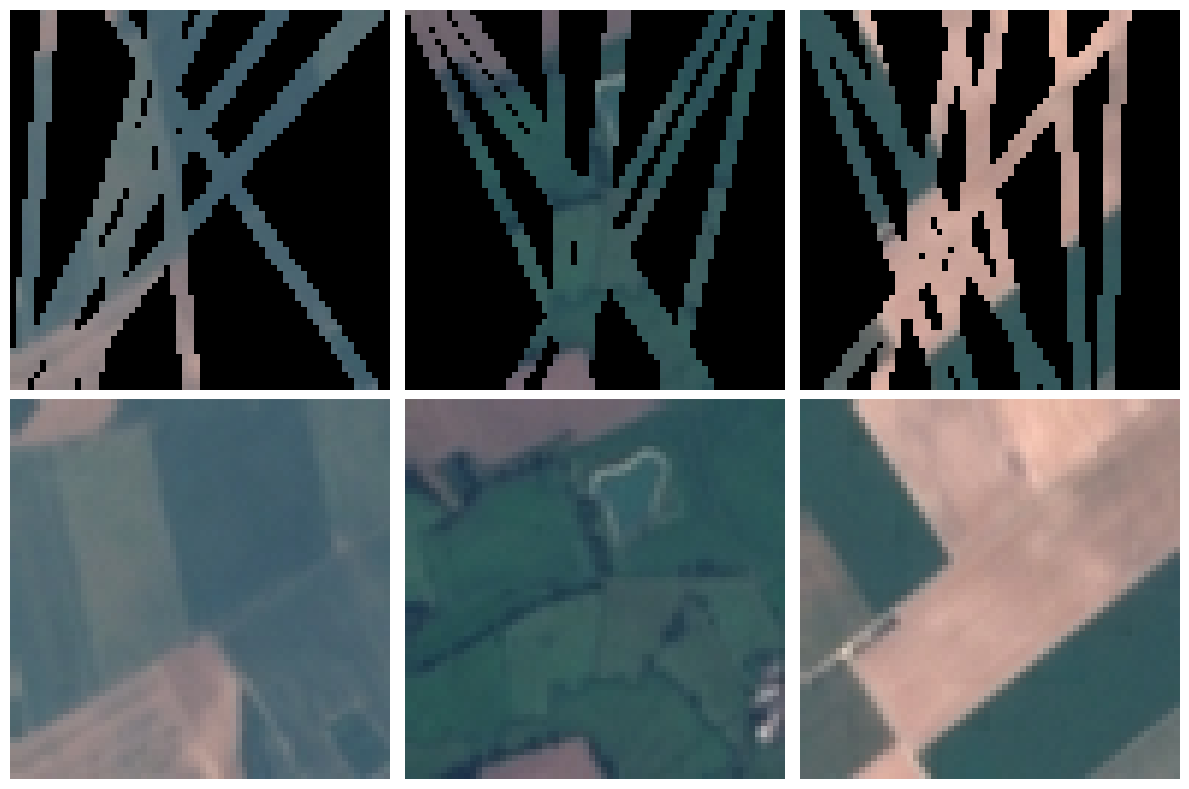

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))  # Adjust figsize as needed
a,b = next(train_generator)
for i in range(3):
  # Plot image on each subplot
  axes[0,i].imshow(a[i])  # Use cmap='gray' if your images are grayscale
  axes[0,i].axis('off')  # Turn off axis
  axes[1,i].imshow(b[i])  # Use cmap='gray' if your images are grayscale
  axes[1,i].axis('off')  # Turn off axis

plt.tight_layout()  # Adjust subplots to fit into the figure area.
plt.show()

###Define my model

- The encoder is responsible for reducing the input dimensionality and extracting key features from the image. This is done through a series of convolutional layers followed by normalization and pooling.
- The bottleneck layer represents the point of maximum information compression. This layer has a high number of filters, meaning it contains a lot of information extracted from the input.
- The decoder is responsible for reconstructing the complete image from the compressed representation provided by the encoder through a series of upsampling operations and concatenation of feature maps extracted by the encoder.
- Rectified Linear Unit (ReLU) is chosen as the activation function for all convolutional layers.
- Batch normalization is used to speed up convergence and improve the stability of the model during training.

In [ ]:
input_img = Input(shape=(64, 64, 3))

# Encoder layers
x1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x2 = BatchNormalization()(x1)
x3 = Conv2D(64, (3, 3), activation='relu', padding='same')(x2)
x4 = BatchNormalization()(x3)
x5 = MaxPooling2D((2, 2), padding='same')(x4)

x6 = Conv2D(128, (3, 3), activation='relu', padding='same')(x5)
x7 = BatchNormalization()(x6)
x8 = Conv2D(128, (3, 3), activation='relu', padding='same')(x7)
x9 = BatchNormalization()(x8)
x10 = MaxPooling2D((2, 2), padding='same')(x9)

# Bottleneck
bottleneck = Conv2D(256, (3, 3), activation='relu', padding='same')(x10)

# Decoder layers
x11 = Conv2D(128, (3, 3), activation='relu', padding='same')(bottleneck)
x12 = BatchNormalization()(x11)
x13 = UpSampling2D((2, 2))(x12)

x14 = Concatenate()([x8, x13])
x15 = Conv2D(128, (3, 3), activation='relu', padding='same')(x14)
x16 = BatchNormalization()(x15)
x17 = UpSampling2D((2, 2))(x16)

x18 = Concatenate()([x4, x17])
x19 = Conv2D(64, (3, 3), activation='relu', padding='same')(x18)
x20 = BatchNormalization()(x19)

decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x20)

model = Model(input_img, decoded)

###Compile the model
- The mean squared error is used as a loss function and metric.
- Adam is used as the optimizer with the default learning rate.


In [ ]:
optimizer = Adam()
model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 64, 64, 64)           1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 64, 64, 64)           256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 64, 64, 64)           36928     ['batch_normalization[0][0

###Train the model
I define two callbacks that are useful in the training process:
- ModelCheckpoint to always save the best model during training
- EarlyStopping to stop training after no improvement on validation loss is recorded for n epochs

In [ ]:
checkpoint = ModelCheckpoint("best_model.keras", monitor='val_loss', verbose=1, save_best_only=True, mode='min')

earlystop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

callbacks = [checkpoint, earlystop]

history = model.fit(train_generator,
                    steps_per_epoch = len(train_dataset) / batch_size,
                    epochs = 100,
                    validation_data = valid_generator,
                    validation_steps = len(validation_dataset) / batch_size,
                    callbacks=callbacks)

Epoch 1/100
2875/2875 [==============================] - ETA: 0s - loss: 0.0062 - mse: 0.0062
Epoch 1: val_loss improved from inf to 0.00381, saving model to best_model.keras
2875/2875 [==============================] - 80s 21ms/step - loss: 0.0062 - mse: 0.0062 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 2/100
2875/2875 [==============================] - ETA: 0s - loss: 0.0043 - mse: 0.0043
Epoch 2: val_loss improved from 0.00381 to 0.00357, saving model to best_model.keras
2875/2875 [==============================] - 100s 35ms/step - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 3/100
2875/2875 [==============================] - ETA: 0s - loss: 0.0036 - mse: 0.0036
Epoch 3: val_loss improved from 0.00357 to 0.00324, saving model to best_model.keras
2875/2875 [==============================] - 62s 22ms/step - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0032 - val_mse: 0.0032
Epoch 4/100
2875/2875 [==============================] - ETA: 0s - loss: 0.0034 - mse: 0.00

###Load the best model


In [ ]:
best_model = load_model("best_model.keras")
best_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 64, 64, 64)           1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 64, 64, 64)           256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 64, 64, 64)           36928     ['batch_normalization[0][0

###Evaluation of the model

Evaluation on the test set was done by computing the mse over 10000 images from the test set and repeating the process 10 times. Finally, the mean and standard deviation is calculated.

In [ ]:
num_repetitions = 10
num_images_per_repetition = 10000
mse_values = []

for _ in tqdm(range(num_repetitions)):
    mse_per_repetition = []
    for _ in range(num_images_per_repetition // batch_size):
        data = next(test_generator)
        inpainted_images = best_model.predict(data[0], verbose=0)
        mse_per_batch = np.mean(np.square(data[1] - inpainted_images))
        mse_per_repetition.append(mse_per_batch)

    mse_values.append(np.mean(mse_per_repetition))
    print(f"\nMSE for this iteration -> {np.mean(mse_per_repetition):.5f}")

mean_mse = np.mean(mse_values)
std_dev_mse = np.std(mse_values)

print(f"Mean MSE over {num_repetitions} repetitions and {num_images_per_repetition} images: {mean_mse:.5f}")
print(f"Standard Deviation of MSE over {num_repetitions} repetitions: {std_dev_mse:.5f}")

 10%|█         | 1/10 [01:48<16:20, 108.95s/it]


MSE for this iteration -> 0.00257


 20%|██        | 2/10 [03:35<14:20, 107.62s/it]


MSE for this iteration -> 0.00255


 30%|███       | 3/10 [05:41<13:32, 116.10s/it]


MSE for this iteration -> 0.00253


 40%|████      | 4/10 [07:32<11:22, 113.78s/it]


MSE for this iteration -> 0.00255


 50%|█████     | 5/10 [09:59<10:29, 125.96s/it]


MSE for this iteration -> 0.00252


 60%|██████    | 6/10 [11:49<08:01, 120.45s/it]


MSE for this iteration -> 0.00254


 70%|███████   | 7/10 [14:17<06:28, 129.49s/it]


MSE for this iteration -> 0.00257


 80%|████████  | 8/10 [16:26<04:18, 129.31s/it]


MSE for this iteration -> 0.00259


 90%|█████████ | 9/10 [18:14<02:02, 122.82s/it]


MSE for this iteration -> 0.00257


100%|██████████| 10/10 [20:23<00:00, 122.39s/it]


MSE for this iteration -> 0.00257
Mean MSE over 10 repetitions and 10000 images: 0.00256
Standard Deviation of MSE over 10 repetitions: 0.00002


###Original vs Target vs Generated Images

1/1 [==============================] - 0s 25ms/step


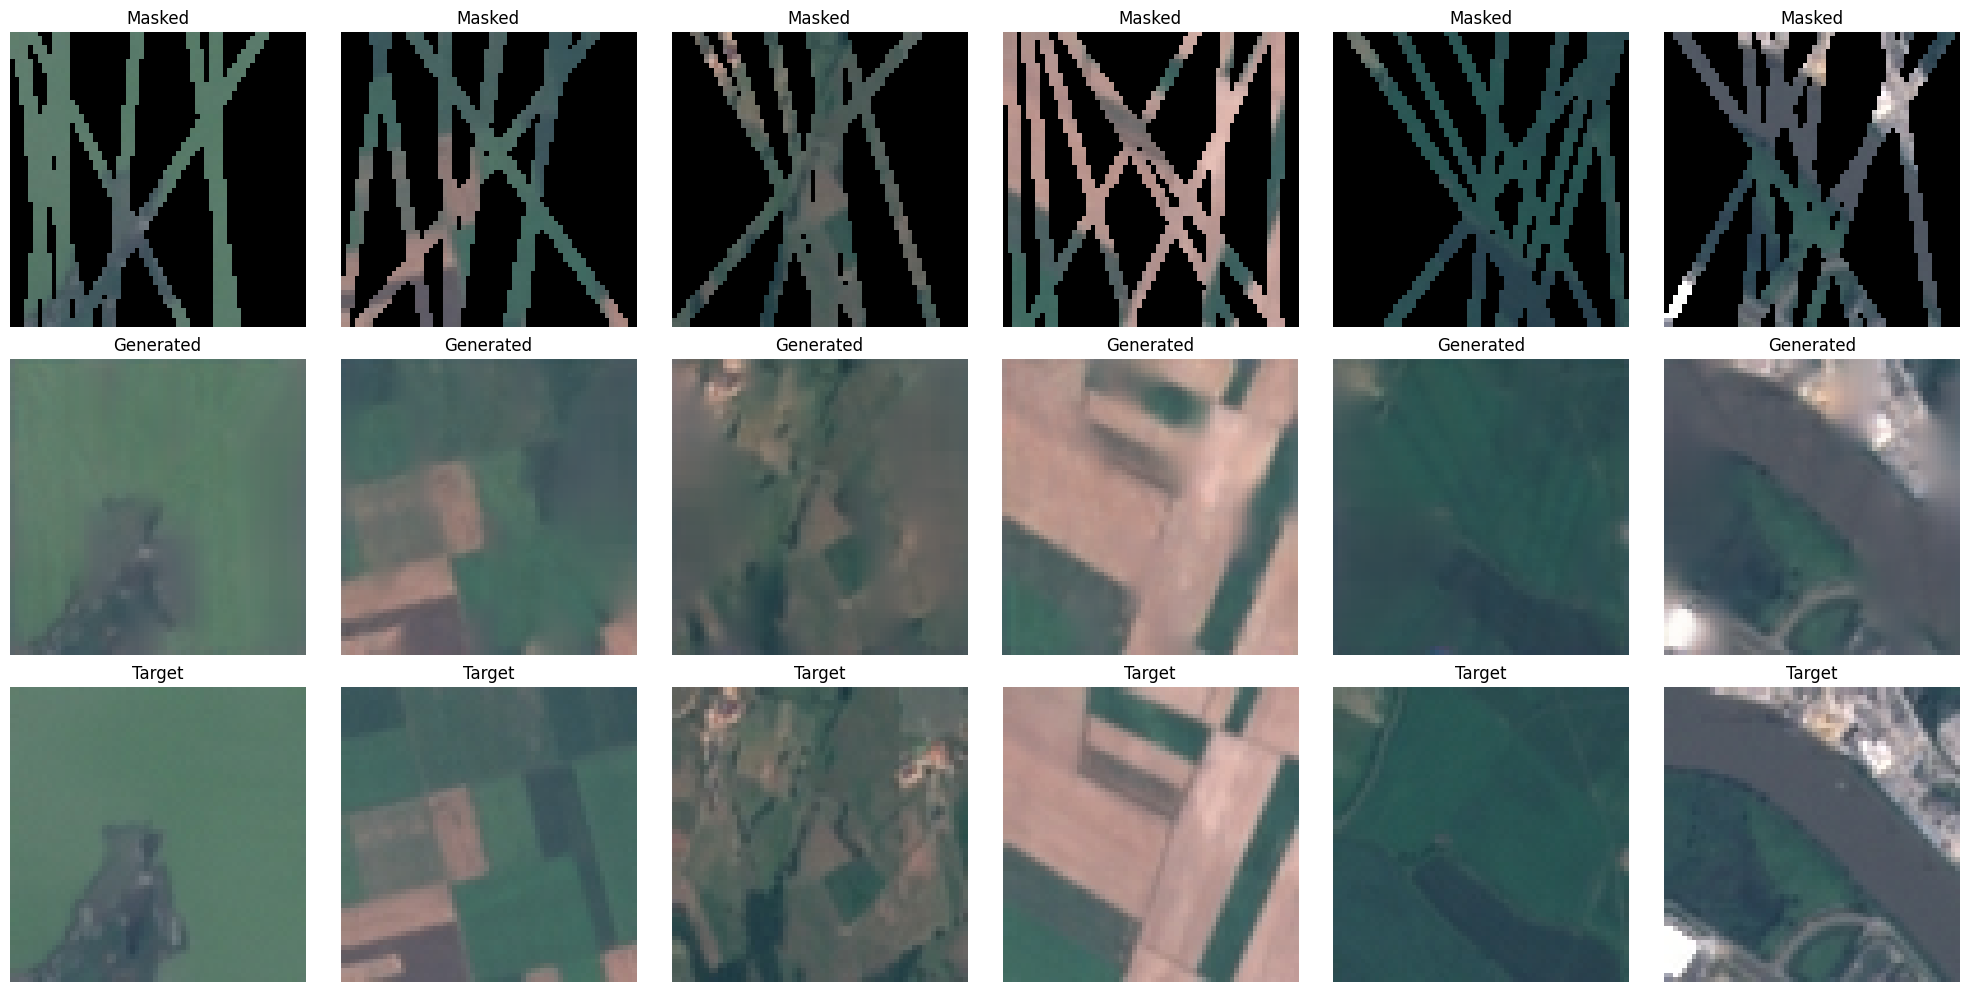

In [ ]:
def compare_images(original_images, generated_images, target_images):
    fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(20, 10))
    for i in range(6):
        # Plot masked image
        axes[0,i].imshow(original_images[i])
        axes[0,i].axis('off')
        axes[0,i].set_title('Masked', fontsize=12)

        # Plot generated image
        axes[1,i].imshow(generated_images[i])
        axes[1,i].axis('off')
        axes[1,i].set_title('Generated', fontsize=12)

        # Plot target image
        axes[2,i].imshow(target_images[i])
        axes[2,i].axis('off')
        axes[2,i].set_title('Target', fontsize=12)

    plt.tight_layout()
    plt.show()

a,b = next(test_generator)
generated_images = best_model.predict(a)
compare_images(a, generated_images, b)